# Kaggle比赛：预测房价

## 定义一些工具性函数

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


下面设计一个download函数，用来下载数据集，并将数据集缓存在本地目录下，并且可以判断对应目录是否已经有数据集了

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

另外准备两个函数，一个用来下载并解压一个zip或者tar文件，另一个将所有DATA_HUB中的数据集都下载下来：

In [3]:
def download_extract(name , folder = None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

## 下载并准备数据集

In [4]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

使用`pandas`加载包含训练数据和测试数据的两个CSV文件

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


以下是通过data的iloc属性查看前四个房子的前四个与最后两个特征，以及相应的标签

In [7]:
print(train_data.iloc[0:4 , [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


## 数据预处理
可以看到每个样本具有特征ID，这会使得网络根据ID背下来价格，所以在送入网络之前，需要将这个ID删掉

In [8]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))


进一步进行核心的预处理工作，将所有缺失的值替换为相应特征的平均值，同时为了**将所有特征放在一个共同的尺度上**，通过将特征重新缩放到零均值和单位方差来标准化数据：
$$x \leftarrow \frac{x - \mu}{\sigma}$$
下面这段代码便是首先进行了零均值和单位方差变化，使得此时只需要将nan的数据直接替换成0即可，也就相当于将其替换为了此时的均值。

In [9]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index   # 非字符串类型的索引
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理完连续的数值后，处理离散值，使用独热编码替换他们，具体实现可以直接借助pandas包：

In [10]:
all_features = pd.get_dummies(all_features, dummy_na=True)  # 独热编码
all_features.shape

(2919, 330)

In [11]:
# 在转换为张量之前，先检查数据类型
print("数据类型检查:")
print(all_features.dtypes.value_counts())
print("\n包含object类型的列:")
print(all_features.select_dtypes(include=['object']).columns.tolist())
# 将所有数据统一转换为float32类型
all_features = all_features.astype('float32')
print(f"\n转换后的数据类型: {all_features.dtypes.value_counts()}")

数据类型检查:
bool       294
float64     36
Name: count, dtype: int64

包含object类型的列:
[]

转换后的数据类型: float32    330
Name: count, dtype: int64


可以通过code的插件来看一看此时的数据形式，此时panda已经将所有的字符值都变成了独立的独热形式，然后就可以借助values属性，将其提取为numpy格式，再进一步转换为张量，用于训练：

In [12]:

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 训练
训练一个简单的线性模型，作为一个基线模型：

In [38]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features,128),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(128, 64),
        # nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(64, 32) , 
        nn.ReLU(),
        nn.Linear(32, 1) 
        )
    return net

对于房价而言，往往关注的是他的相对误差，因为同样的价格差距可能在不同的地区产生不同的影响作用：
$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [14]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

同时，在这里将使用**Adam优化器**，主要那个因为它对初始学习率不那么敏感：

In [15]:
def train(net, train_features, train_labels, test_features, test_labels,
            num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                lr = learning_rate,
                                weight_decay = weight_decay)
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            net.eval()
            with torch.no_grad():
                test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K折交叉验证

In [16]:
def get_k_fold_data(k , i ,X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size , (j+ 1) * fold_size)
        X_part , y_part = X[idx , :] , y[idx]
        if j == i:
            X_valid , y_valid = X_part , y_part
        elif X_train is None:
            X_train , y_train = X_part , y_part
        else:
            X_train = torch.cat([X_train , X_part] , 0)
            y_train = torch.cat([y_train , y_part] , 0)
    return X_train, y_train, X_valid, y_valid

接下来基于K折交叉验证，训练k次，并返回训练和验证误差的平均值

In [17]:
def k_fold(k , X_train , y_train , num_epochs , learning_rate , weight_decay, batch_size):
    train_l_sum , valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k , i , X_train , y_train)
        net = get_net()
        train_ls , valid_ls = train(net , *data, num_epochs , learning_rate , weight_decay , batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1} , 训练log rmse: {float(train_ls[-1]):f}, '
              f'验证log rmse: {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型调参与训练执行

折1 , 训练log rmse: 0.108668, 验证log rmse: 0.167562
折2 , 训练log rmse: 0.098733, 验证log rmse: 0.153301
折3 , 训练log rmse: 0.103993, 验证log rmse: 0.153690
折4 , 训练log rmse: 0.096745, 验证log rmse: 0.123421
折5 , 训练log rmse: 0.097829, 验证log rmse: 0.161657
5-折验证: 平均训练log rmse : 0.101194, 平均验证log rmse: 0.151926


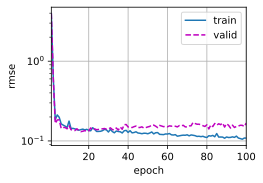

In [43]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.01, 1, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse : {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 保存训练结果提交Kaggle

In [23]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    net.train()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.099110


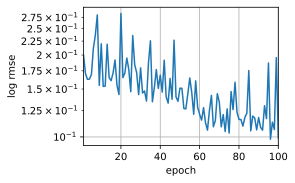

In [24]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)